In [19]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [20]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [21]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [22]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [23]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [24]:
# View all of the classes that automap found
print(Base.classes.keys())


['measurement', 'station']


In [25]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [26]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [27]:
# Find the most recent date in the dataset
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date

'2017-08-23'

In [28]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Convert the most recent date to a datetime object
most_recent_date_dt = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year from the most recent date
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

In [29]:
# Perform a query to retrieve the data and precipitation scores
precipitation_data = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= one_year_ago)
    .all()
)

In [30]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
column_names = ['Date', 'Precipitation']
precipitation_df = pd.DataFrame(precipitation_data, columns=column_names)

In [31]:
# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values('Date')

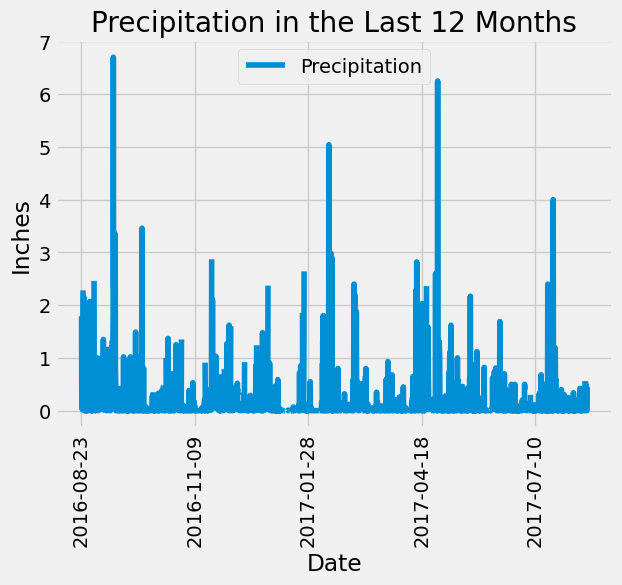

In [32]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='Date', y='Precipitation', rot=90)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation in the Last 12 Months')
plt.show()

In [33]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df.describe()
summary_statistics

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [34]:
# Design a query to calculate the total number of stations
total_stations = session.query(func.count(Measurement.station.distinct())).scalar()

total_stations 



9

In [35]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)
most_active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [36]:
# Find the most active station
most_active_station = (
        session.query(Measurement.station, func.count(Measurement.station))
        .group_by(Measurement.station)
        .order_by(func.count(Measurement.station).desc())
        .first()
    )

if most_active_station:
        # Extract the station ID
        most_active_station_id = most_active_station[0]

        # Query to calculate lowest, highest, and average temperatures for the most active station
        temp_stats_results = (
            session.query(
                func.min(Measurement.tobs).label('min_temperature'),
                func.max(Measurement.tobs).label('max_temperature'),
                func.avg(Measurement.tobs).label('avg_temperature')
            )
            .filter(Measurement.station == most_active_station_id)
            .all()
        )

        # Extract the results
        temp_stats = {
            "min_temperature": temp_stats_results[0].min_temperature,
            "max_temperature": temp_stats_results[0].max_temperature,
            "avg_temperature": temp_stats_results[0].avg_temperature
        }
temp_stats_results

[(54.0, 85.0, 71.66378066378067)]

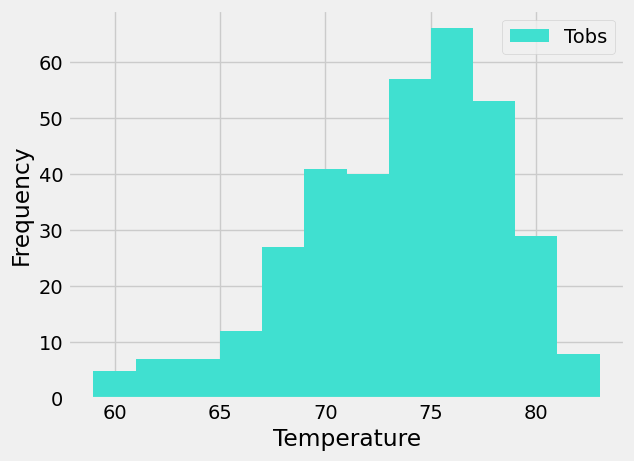

In [37]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_station_id = most_active_stations[0][0]

temperature_data = (
    session.query(Measurement.date, Measurement.tobs)
    .filter(Measurement.station == most_active_station_id)
    .filter(Measurement.date >= one_year_ago)
    .all()
)

# Create a Pandas DataFrame from the query results
column_names = ['Date', 'Temperature']
temperature_df = pd.DataFrame(temperature_data, columns=column_names)

# Plot the results as a histogram
plt.hist(temperature_df['Temperature'], bins=12, color='turquoise', label='Tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='-')
plt.legend()
plt.show()


# Close Session

In [38]:
# Close Session
session.close()